BloomTech Data Science

*Unit 2, Sprint 1, Module 3*

---

In [72]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Ridge Regression

For this project, you'll return to the Tribecca Condo dataset. But this time, you'll look at the _entire_ dataset and try to predict property sale prices.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

## Directions

The tasks for this project are the following:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function to engineer two subset your dataset to one-family dwellings whose price is between \\$100,000 and \\$2,000,000.
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline mean absolute error for your dataset.
- **Task 6:** Build and train a `OneHotEncoder`, and transform `X_train` and `X_test`.
- **Task 7:** Build and train a `LinearRegression` model.
- **Task 8:** Build and train a `Ridge` model.
- **Task 9:** Calculate the training and test mean absolute error for your `LinearRegression` model.
- **Task 10:** Calculate the training and test mean absolute error for your `Ridge` model.
- **Task 11:** Create a horizontal bar chart showing the 10 most influencial features for your `Ridge` model. 

**Note**

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `sklearn`

In [73]:
import matplotlib.pyplot as plt
import pandas as pd

# I. Wrangle Data

In [74]:
def wrangle(filepath):
    # Import csv file
    cols = ['BOROUGH', 'NEIGHBORHOOD',
            'BUILDING CLASS CATEGORY', 'GROSS SQUARE FEET',  
            'YEAR BUILT', 'SALE PRICE', 'SALE DATE']
    df = pd.read_csv(filepath, usecols=cols,
                     parse_dates=['SALE DATE'],
                     index_col = ['SALE DATE']).sort_values(by='SALE DATE')

    # Too much wrangling required for full data set
    # df = pd.read_csv(filepath, parse_dates=['SALE DATE'],
    #                  index_col = ['SALE DATE']).sort_values(by='SALE DATE')

    #Wrangling Constants
    threshold = 10
    too_many_nulls_for_col = 50
    
    #Format Column Names
    df.columns = df.columns.str.replace(' ', '_').str.upper()

    #Convert String to Int
    df['SALE_PRICE'] = (df['SALE_PRICE'].str.strip().str
                        .replace('[$," ", ","]', '').astype(int) )

    #Identify Borough as dtype object
    df['BOROUGH'] = df['BOROUGH'].astype(object)

    #Boolean Mask Restrictions**************************************************

    # In 100k - 2000k Price Range
    mask = ( (df.loc[:]['SALE_PRICE'] >= 100000) 
            & (df.loc[:]['SALE_PRICE'] <= 2000000) )
    
    # Single Family Dwellings
    mask = mask & (df.loc[:]['BUILDING_CLASS_CATEGORY']
                   == '01 ONE FAMILY DWELLINGS')
    
    # Gross Square Feet Not Zero
    mask = mask & (df.loc[:]['GROSS_SQUARE_FEET']>0)
    
    #Apply Restrictions
    df = df[mask]
    #***************************************************************************

    #Remove Single Value, High-Cardinality, and Null Columns
    drop = [col for col in df.nunique().index
            if (df[col].nunique()==1 or (df[col].dtype=='object' 
                and df[col].nunique()>threshold) 
                or (df[col].isnull().sum() > too_many_nulls_for_col) )]
    print("Columns Dropped: ", drop)
    df = df.drop(columns=drop)

    #Drop Rows With Null Values
    df = df.dropna(axis=0)

    return df

filepath = DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv'

df = wrangle(filepath)

Columns Dropped:  ['NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY']


In [94]:
print("Dataframe Info:"); print()
for col in df:
  print(col + ": " + str(df[col].nunique()) + " unique " + str(df[col].dtype) + "s")
print(); print("Shape:", df.shape); print()
print("Nulls:");print(df.isnull().sum())

Dataframe Info:

BOROUGH: 5 unique objects
GROSS_SQUARE_FEET: 1050 unique float64s
YEAR_BUILT: 88 unique float64s
SALE_PRICE: 991 unique int64s

Shape: (3123, 4)

Nulls:
BOROUGH              0
GROSS_SQUARE_FEET    0
YEAR_BUILT           0
SALE_PRICE           0
dtype: int64


**Task 1:** Use the above `wrangle` function to import the `NYC_Citywide_Rolling_Calendar_Sales.csv` file into a DataFrame named `df`.

**Task 2:** Modify the above `wrangle` function so that:

- The column `'SALE DATE'` becomes the `DatetimeIndex`.
- The dtype for the `'BOROUGH'` column is `object`, not `int`.
- The dtype for the `'SALE PRICE'` column is `int`, not `object`.
- The dataset includes only one-family dwellings (`BUILDING CLASS CATEGORY == '01 ONE FAMILY DWELLINGS'`).
- The dataset includes only properties whose sale price is between \\$100,000 and \\$2,000,000.

# II. Split Data

**Task 3:** Split your dataset into the feature matrix `X` and the target vector `y`. You want to predict `'SALE_PRICE'`.

In [76]:
target = 'SALE_PRICE'
y = df[target]
X = df.drop(columns=target)

**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from January to March 2019. 
- Your test set should include data from April 2019.

In [77]:
pd.to_datetime('March 2019').month

mask = (df.index.month <= 3) & (df.index.year == 2019)


X_train, y_train = X[mask], y[mask]
X_test, y_test = X[~mask], y[~mask]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2486, 3) (2486,)
(637, 3) (637,)


# III. Establish Baseline

**Task 5:** Since this is a **regression** problem, you need to calculate the baseline mean absolute error for your model.

In [78]:
from sklearn.metrics import mean_absolute_error
baseline_pred = [y_train.mean()] * len(y_train)
baseline_mae = mean_absolute_error(y_train, baseline_pred)
print('Baseline MAE:', baseline_mae)

Baseline MAE: 216725.1356183526


# IV. Build Model 

**Task 6:** Build and train a `OneHotEncoder` and then use it to transform `X_train` and `X_test`.

In [79]:
from category_encoders import OneHotEncoder
ohe = OneHotEncoder(use_cat_names=True)
ohe.fit(X_train)

XT_train = ohe.transform(X_train)
XT_test = ohe.transform(X_test)

print(list(XT_train.columns))

['BOROUGH_3.0', 'BOROUGH_4.0', 'BOROUGH_5.0', 'BOROUGH_2.0', 'BOROUGH_1.0', 'GROSS_SQUARE_FEET', 'YEAR_BUILT']


**Task 7:** Build and train a `LinearRegression` model named `model_lr`. Remember to train your model using your _transformed_ feature matrix.

In [80]:
from sklearn.linear_model import LinearRegression, Ridge
model_lr = LinearRegression()
model_lr.fit(XT_train, y_train)

LinearRegression()

**Task 8:** Build and train a `Ridge` model named `model_r`. Remember to train your model using your _transformed_ feature matrix.

In [81]:
model_r = Ridge(alpha=5.0)
model_r.fit(XT_train, y_train)

Ridge(alpha=5.0)

# V. Check Metrics

**Task 9:** Check the training and test metrics for `model_lr`.

In [82]:
training_mae_lr = mean_absolute_error(y_train, model_lr.predict(XT_train))
test_mae_lr = mean_absolute_error(y_test, model_lr.predict(XT_test))

print('Linear Training MAE:', training_mae_lr)
print('Linear Test MAE:', test_mae_lr)

Linear Training MAE: 180213.46022236146
Linear Test MAE: 185899.4332001807


**Task 10:** Check the training and test metrics for `model_r`.

In [83]:
training_mae_r = mean_absolute_error(y_train, model_r.predict(XT_train))
test_mae_r = mean_absolute_error(y_test, model_r.predict(XT_test))

print('Ridge Training MAE:', training_mae_r)
print('Ridge Test MAE:', test_mae_r)

Ridge Training MAE: 180208.67646852726
Ridge Test MAE: 185738.6004637565


**Stretch Goal:** Calculate the training and test $R^2$ scores `model_r`.

In [84]:
# Caculate R^2 score
from sklearn.metrics import r2_score
training_r2_lr = r2_score(y_train, model_lr.predict(XT_train))
test_r2_lr = r2_score(y_test, model_lr.predict(XT_test))


print('Linear Training R2:', training_r2_lr)
print('Linear Test R2:', test_r2_lr)

Linear Training R2: 0.30384199639253995
Linear Test R2: 0.24929110699021395


# IV. Communicate Results

**Task 11:** Create a horizontal barchart that plots the 10 most important coefficients for `model_r`, sorted by absolute value. Your figure should look like our example from class:

LINEAR MODEL ABS COEFFICIENTS
                      SALE_PRICE
BOROUGH_2.0        175383.362184
BOROUGH_3.0        134151.132274
BOROUGH_1.0        121334.633045
BOROUGH_5.0        108944.751210
BOROUGH_4.0         28842.348075
GROSS_SQUARE_FEET     233.693941
YEAR_BUILT            204.386855



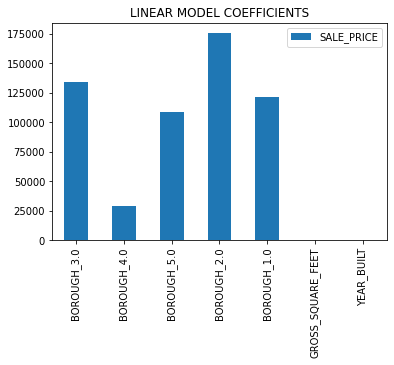

In [85]:
print("LINEAR MODEL ABS COEFFICIENTS")
coef_df = pd.DataFrame(model_lr.coef_, index=list(XT_train.columns), columns=[target])
print(coef_df.abs().sort_values(by=target, ascending=False)); print()

coef_df.abs().plot(kind='bar', title='LINEAR MODEL COEFFICIENTS');

RIDGE MODEL ABS COEFFICIENTS
                      SALE_PRICE
BOROUGH_3.0        155896.783420
BOROUGH_2.0        148389.651092
BOROUGH_5.0         84072.882536
BOROUGH_4.0         52410.344531
BOROUGH_1.0         24155.405676
GROSS_SQUARE_FEET     233.693737
YEAR_BUILT            189.514373



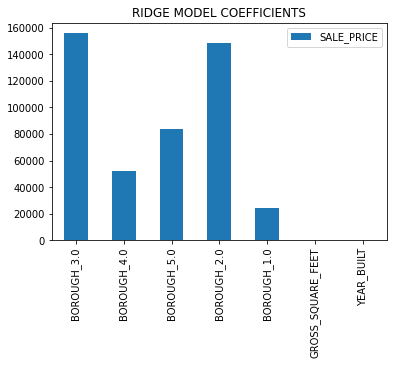

In [86]:
print("RIDGE MODEL ABS COEFFICIENTS")
coef_df = pd.DataFrame(model_r.coef_, index=list(XT_train.columns), columns=[target])
print(coef_df.abs().sort_values(by=target, ascending=False)); print()

coef_df.abs().plot(kind='bar', title='RIDGE MODEL COEFFICIENTS');